In [1]:
import torch
import os
import sys
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import torch.distributions as dist

from utils.utils import set_seed
from models.toy_gmm import TwoPointGMM
from rectified_flow.rectified_flow import RectifiedFlow
from rectified_flow.coupling_dataset_toy import CouplingDataset, coupling_collate_fn 
from models.toy_mlp import MLPVelocityConditioned

set_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
n_samples = 50000
pi0 = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
pi1 = TwoPointGMM(x=15.0, y=7.5, std=0.5)
D0 = pi0.sample([n_samples])
D1, labels = pi1.sample_with_labels([n_samples])
labels.tolist()
print(labels.shape)

torch.Size([50000])


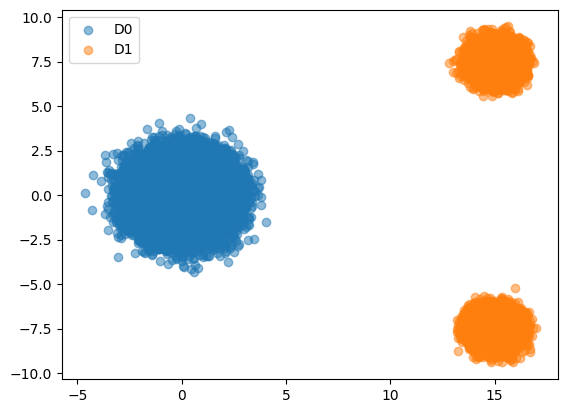

In [9]:
plt.scatter(D0[:, 0], D0[:, 1], alpha=0.5, label='D0')
plt.scatter(D1[:, 0], D1[:, 1], alpha=0.5, label='D1')
plt.legend()

Epoch 0, Loss 24.994182586669922
Epoch 1, Loss 2.944904327392578
Epoch 2, Loss 1.5714318752288818
Epoch 3, Loss 1.4110760688781738
Epoch 4, Loss 1.3911547660827637
Epoch 5, Loss 1.423811674118042
Epoch 6, Loss 1.411256194114685
Epoch 7, Loss 1.436024785041809
Epoch 8, Loss 1.5371184349060059
Epoch 9, Loss 1.2897231578826904
Epoch 10, Loss 1.4685145616531372
Epoch 11, Loss 1.4904149770736694
Epoch 12, Loss 1.371236801147461
Epoch 13, Loss 1.3142253160476685
Epoch 14, Loss 1.3628344535827637
Epoch 15, Loss 1.432525873184204
Epoch 16, Loss 1.3576865196228027
Epoch 17, Loss 1.3409606218338013
Epoch 18, Loss 1.4920743703842163
Epoch 19, Loss 1.456739902496338
Epoch 20, Loss 1.4218049049377441
Epoch 21, Loss 1.3491103649139404
Epoch 22, Loss 1.3549535274505615
Epoch 23, Loss 1.3385587930679321
Epoch 24, Loss 1.408439040184021
Epoch 25, Loss 1.4916590452194214
Epoch 26, Loss 1.3507822751998901
Epoch 27, Loss 1.549041986465454
Epoch 28, Loss 1.3163645267486572
Epoch 29, Loss 1.3364475965499878

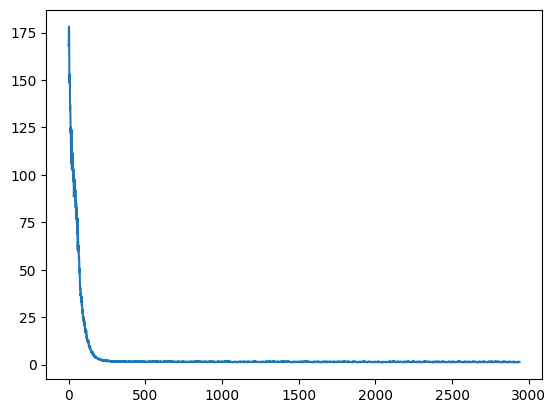

In [ ]:
dataset = CouplingDataset(D1, D0, False, labels)
model = MLPVelocityConditioned(2, hidden_sizes = [128, 128, 128]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

collate_fn = lambda batch: coupling_collate_fn(batch, pi0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False, collate_fn=collate_fn)

rf_func = RectifiedFlow(
    (2),
    model=model,
    interp="sin",
    prior_distribution=pi0,
    device=device,
)

losses = []

for epoch in range(30):
    for i, batch in enumerate(dataloader):
        optimizer.zero_grad()
        X_0, X_1, cond = batch
        X_0 = X_0.to(device)
        X_1 = X_1.to(device)
        cond = torch.tensor(cond).to(device)
        
        loss = rf_func.get_loss(X_0, X_1, labels=cond)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f'Epoch {epoch}, Loss {loss.item()}')
    
plt.plot(losses)

In [11]:
from rectified_flow.samplers import EulerSampler

euler_sampler = EulerSampler(
    rectified_flow=rf_func,
    num_steps=100,
    num_samples=500,
)

labels = torch.zeros(500,).to(device)

euler_sampler.sample_loop(labels = labels)

xtraj.shape torch.Size([101, 500, 2])


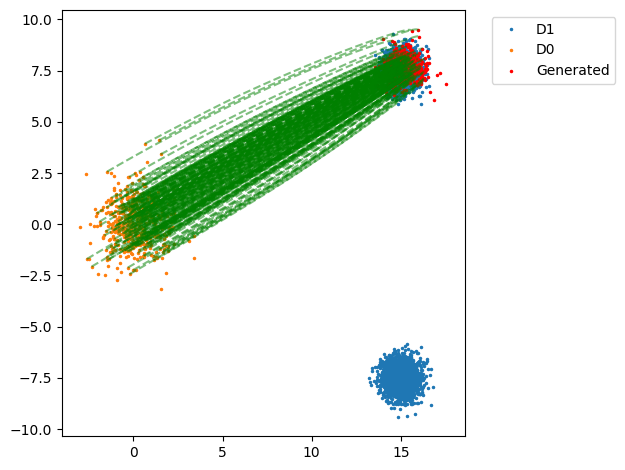

In [12]:
from utils.utils import visualize_2d_trajectories

visualize_2d_trajectories(
    euler_sampler.trajectories, 
    D1[:5000],
    num_trajectories=200,
)

In [14]:
from rectified_flow.samplers import CurvedEulerSampler

curved_sampler = CurvedEulerSampler(
    rectified_flow=rf_func,
    num_steps=100,
    num_samples=500,
)

labels = torch.ones(500,).to(device)

curved_sampler.sample_loop(labels = labels)

xtraj.shape torch.Size([101, 500, 2])


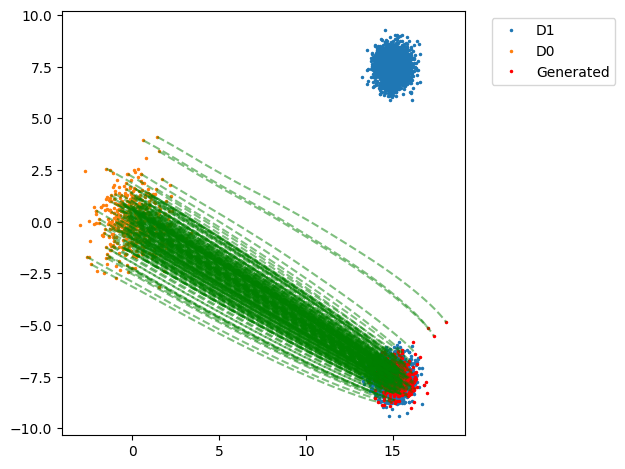

In [15]:
visualize_2d_trajectories(
    curved_sampler.trajectories, 
    D1[:5000],
    num_trajectories=200,
)